In [1]:
import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from dask.distributed import Client

In [2]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)
#cc.querying.get_ncfiles(session,experiment='10_KDS50')

In [25]:
expt = 'HI-02'
start_time = '1870-01-14'
end_time = '1870-12-14'

In [26]:
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

(-80.0, 90.0)

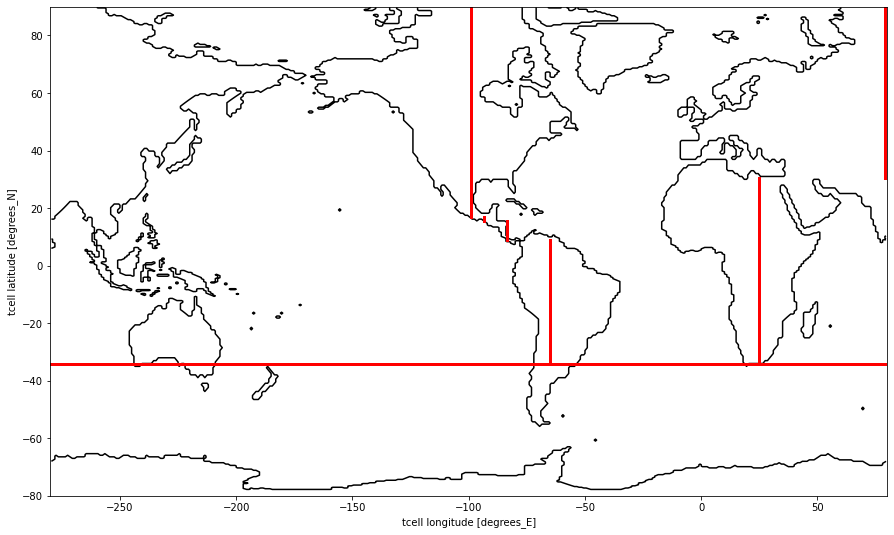

In [27]:
fig=plt.figure(2,(15,9))
ax = plt.subplot()
land_mask.plot.contour(levels=[0.5],colors='k')
ax.plot([-280,80], [-34,-34], 'r', linewidth = 3)
ax.plot([-65,-65], [-34,9], 'r', linewidth = 3)
ax.plot([-83.7,-83.7], [9,15.5], 'r', linewidth = 3)
ax.plot([-93.3,-93.3], [15.5,17], 'r', linewidth = 3)
ax.plot([-99,-99], [17,90], 'r', linewidth = 3)
ax.plot([25,25], [-34,30.5], 'r', linewidth = 3)
ax.plot([79,79], [30.5,90], 'r', linewidth = 3)
ax.set_xlim([-280,80])
ax.set_ylim([-80,90])

In [28]:
## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0)
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0)
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0)
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0)
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0)
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0)
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

Text(0.5, 1.0, 'Indo-Pacific + Southern Ocean Mask')

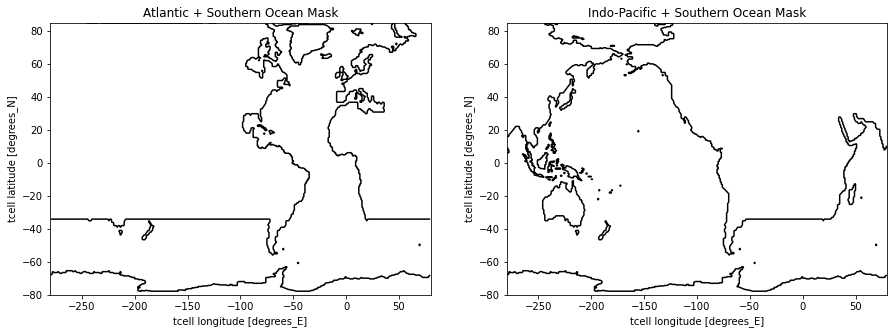

In [29]:
fig, ax=plt.subplots(1,2, figsize=(15,5))

atlantic_sector_map.plot.contour(ax=ax[0],levels=[0.5],colors='k')
ax[0].set_xlim([-280,80])
ax[0].set_ylim([-80,85])
ax[0].set_title('Atlantic + Southern Ocean Mask')
indo_sector_map.plot.contour(ax=ax[1],levels=[0.5],colors='k')
ax[1].set_xlim([-280,80])
ax[1].set_ylim([-80,85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask')

In [30]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

In [31]:
def compute_basin_psi_rho(expt,session, basin_mask, nbound=None, start_time = None, end_time=None):
    rho = 1025 # mean density of sea-water in kg/m^3

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        print('GM is True')
        psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session, n=nbound,start_time = start_time, end_time=end_time)
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6*rho)
    else:
        GM = False
        print('GM is False')

    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound,start_time = start_time, end_time=end_time)
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load()
    if GM:
        psi = psi + psiGM.mean('time')

    return psi

In [32]:
atlantic_psi = compute_basin_psi_rho(expt,session, atlantic_sector_mask, start_time=start_time, end_time=end_time)
indopacific_psi = compute_basin_psi_rho(expt,session, indo_sector_mask, start_time=start_time, end_time=end_time)

GM is True
GM is True


Text(0.5, 0, 'Sv')

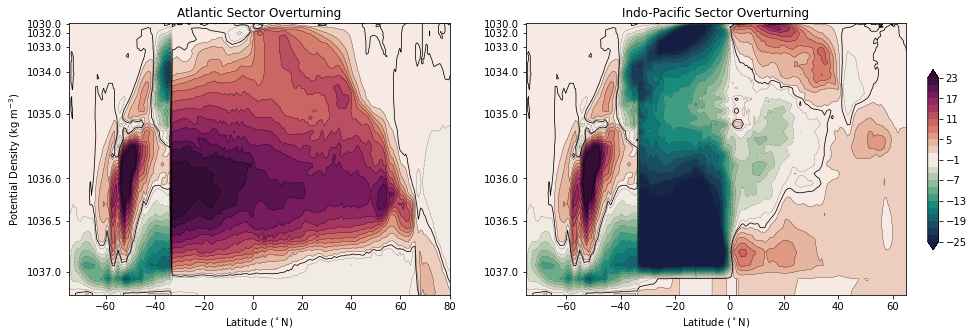

In [33]:
clev=np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set the stretching of the y-axis

fig, ax=plt.subplots(1,2, figsize=(15,5))

## Plotting Atlantic Sector
p1=ax[0].contourf(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
ax[0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[0].set_yticks((yticks-1028)**scfac)
ax[0].set_yticklabels(yticks)
ax[0].set_ylim([0.5**scfac, 9.2**scfac])
ax[0].invert_yaxis()
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude ($^\circ$N)')
ax[0].set_xlim([-75,80])
ax[0].set_title('Atlantic Sector Overturning');


## Plotting Indo-Pacific Sector
p1=ax[1].contourf(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
ax[1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[1].set_yticks((yticks-1028)**scfac)
ax[1].set_yticklabels(yticks)
ax[1].set_ylim([0.5**scfac, 9.2**scfac])
ax[1].invert_yaxis()
ax[1].set_xlabel('Latitude ($^\circ$N)')
ax[1].set_xlim([-75,65])
ax[1].set_title('Indo-Pacific Sector Overturning');

# Plot a colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p1,cax = cax,orientation='vertical')
cb.ax.set_xlabel('Sv')

In [ ]:
# Zonally Averaged Overturning Circulation

In [38]:
expt = 'HI-00'
start_time = '1870-01-14'
end_time = '1870-12-14'

In [39]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time)
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False

In [40]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)

In [41]:
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg = psi_avg + psiGM.mean('time')

psi_avg.load()

<xarray.DataArray (potrho: 80, grid_yu_ocean: 300)>
array([[ 0.0000000e+00,  4.0033069e-03,  1.0962074e-02, ...,
         1.0272663e-03, -7.6172636e-03, -8.8478196e-03],
       [ 0.0000000e+00,  4.0033069e-03,  1.0962074e-02, ...,
        -1.1403480e-03, -1.0291980e-02, -9.4850212e-03],
       [ 0.0000000e+00,  4.0033069e-03,  1.0962074e-02, ...,
        -4.1643535e-03, -1.2647255e-02, -1.0728093e-02],
       ...,
       [ 0.0000000e+00, -1.3783757e-05, -7.5471207e-06, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 -77.75 -77.51 -77.26 ... 89.55 90.0

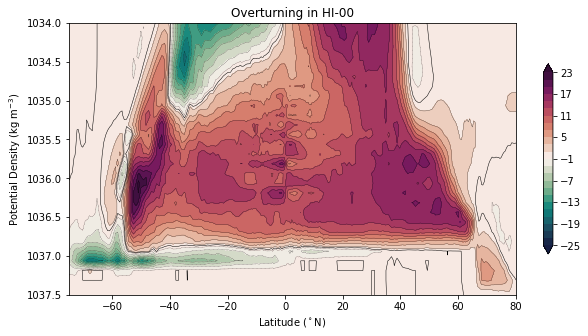

In [42]:
plt.figure(figsize=(10, 5))
clev = np.arange(-25,25,2)
plt.contourf(psi_avg.grid_yu_ocean,psi_avg.potrho, psi_avg, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)

cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);